init

In [1]:
import snappy
from snappy import HashMap

jpy = snappy.jpy
from snappy import ProductIO, File

import fiona

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import numpy as np

import rasterio
import rasterio.mask
from rasterio.enums import Resampling

In [3]:
File = jpy.get_type('java.io.File')
reader = snappy.ProductIO.getProductReader('SEN3')

with fiona.open("../Malta Shape File/MaltaShapeFile.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open('./tif/projected_S3B_SL_2_LST____20210813T093653_20210813T093953_20210813T120050_0179_055_364_2340_LN2_O_NR_004.SEN3.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.descriptions
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "dtype": "float32"})
    with rasterio.open('cropped.tif', 'w', **out_meta) as dst:
        # Read the data from the window and write it to the output raster
        dst.meta
        dst.update_tags(**out_meta)
        dst.write(out_image)

In [36]:
raster = rasterio.open('metaCrop.tif')

# This will print out a short version of the  meta data associated with this file.
print(raster.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 122, 'height': 100, 'count': 2, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.011101493308412638, 0.0, 13.730555595912174,
       0.0, -0.011101493308412638, 36.362360461123046)}
(None, None)


Data visualization units.

In [13]:
# Data visualization units.
#unit = '[ K ]'
unit = '[ °C ]'

long_name = 'Sentinel-3 Land Surface Temperature'

# We need to know the geographical extent of the data, this is contained in the raster object.

bbox = raster.bounds
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
#extent=[35.7, 36.1, 14.1, 14.6]
print (bbox)

BoundingBox(left=13.730555595912174, bottom=35.25221113028178, right=15.084937779538516, top=36.362360461123046)


In [25]:
upscale_factor = 1

# resample data to target shape
data = raster.read(
out_shape=(
    raster.count,
    int(raster.height * upscale_factor),
    int(raster.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
transform = raster.transform * raster.transform.scale(
(raster.width / data.shape[-1]),
(raster.height / data.shape[-2]))

print('Rescaled size: ',np.shape(data[0,:,:]))

Rescaled size:  (100, 122)


In [28]:
# Here we set up the parameters needed to display the geographical data correctly.
fig=plt.figure(figsize=(15, 12))

# Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
#proj = ccrs.epsg(3857)
#ax = plt.axes(projection=proj)
ax = plt.axes(projection=ccrs.PlateCarree())

# The coastline data get downloaded here, there may be a delay the first time you run this notebook.
#ax.coastlines(resolution='10m')
#ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

# Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
# selecting which colour to associate with the NODATA value in the map

color = cm.jet

color.set_bad('white')

#The pixel associated to the NODATA values are masked out.

data = data.astype(np.float16)
data[data == -32768.0] = np.nan

# As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
# These can be retrieved from the extended metadata of the file. 

scale_factor = 0.0020000001

offset = 290

#cal_data = scale_factor * data - 273 + offset
#cal_data = data - 273 + offset

img = plt.imshow(data[0,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
cbar.set_label(unit, fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=14)
plt.savefig('meta10.png')
plt.show()

ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 1080x864 with 2 Axes>

In [ ]:
##https://www.eea.europa.eu/soer/2010/countries/mt/land-use-state-and-impacts-malta
#file:///C:/Users/Massimo/Downloads/20BSCES022.pdf

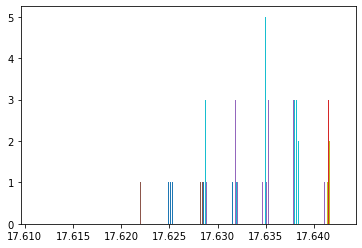

In [119]:
plt.hist(cal_data[0,:,:])
plt.show() 

In [143]:
array = np.stack(cal_data[0])  # (n bands by n rows by n cols array)
result = array.mean(axis=0)
print(result)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [ ]:
import csv, os
lst = cal_data[0,:,:]
#for i in range(len(lst[1])):
    #if lst[i] != '':
        #print(lst[i])

with open('test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["LST"])

    for i in range(len(lst)):
        writer.writerow([lst[i]]) 


In [ ]:
with open('test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["LST"])

    for i in range(len(cal_data[1])):
        writer.writerow([cal_data[i]]) 